In [1]:
import torch,torchvision
import pandas as pd
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultPredictor,DefaultTrainer,SimpleTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
data = pd.read_csv('./data/labels_train.csv')

In [3]:
data.columns

Index(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], dtype='object')

In [4]:
def load_data(data_type='train'):
    if data_type == 'train':
        data = pd.read_csv('./data/labels_trainval.csv')
    else:
        data = pd.read_csv('./data/labels_train.csv')
    print(data_type)
    dataset = []
    for idx in tqdm(range(len(data))):
        record = {}
        info = data.iloc[idx]
        xmin,ymin,xmax,ymax = info['xmin'],info['ymin'],info['xmax'],info['ymax']
        height,width = cv2.imread(f'./data/images/{info["frame"]}').shape[:2]
        file_path = f'./data/images/{info["frame"]}'
        class_id = int(info['class_id'] - 1)
        objs = [{'bbox':[xmin,ymin,xmax,ymax],'bbox_mode':BoxMode.XYXY_ABS,'iscrowd':0,'category_id':class_id}]
        record['xmin'] = xmin
        record['ymin'] = ymin
        record['xmax'] = xmax
        record['ymax'] = ymax
        record['height'] = height
        record['image_id'] = idx
        record['width'] = width
        record['file_name'] = file_path
        record['class_id'] = class_id
        record['annotations'] = objs
        dataset.append(record)
    return dataset

In [5]:
classes = ['car', 'truck', 'pedestrian', 'bicyclist', 'light']

In [6]:
len(classes)

5

In [7]:
DatasetCatalog.register('train_data',lambda : load_data())
MetadataCatalog.get('train_data').set(thing_classes=classes)
metadata_train = MetadataCatalog.get('train_data')
DatasetCatalog.register('val_data',lambda : load_data('val'))
MetadataCatalog.get('val_data').set(thing_classes=classes)
metadata_train = MetadataCatalog.get('val_data')

In [8]:
import os

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_data",)
cfg.DATASETS.TEST = ('val_data',)   # no metrics implemented for this dataset
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [10]:
# cfg.MODEL.WEIGHTS = cfg.OUTPUT_DIR+'/'+"model_final.pth"
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

NameError: name 'cfg' is not defined

In [ ]:
import random

In [ ]:
random_img = random.choice(os.listdir('./data/images/'))

In [11]:
random_img = './data/images/' + random_img

NameError: name 'random_img' is not defined

In [12]:
import matplotlib.pyplot as plt

In [20]:
cfg.DATASETS.TRAIN[0]

'train_data'

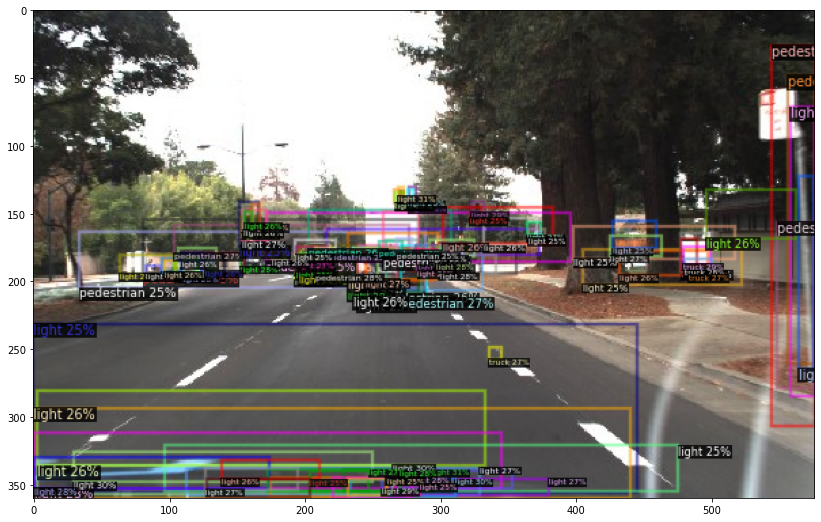

In [15]:
random_img = cv2.imread(random_img)
out = predictor(random_img)
out = out['instances']
from detectron2.utils.visualizer import Visualizer, ColorMode
v = Visualizer(random_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(out.to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [16]:
import matplotlib.pyplot as plt

In [19]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("val_data", ("bbox",), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "val_data")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))

In [ ]:
out

In [ ]:
instances = []